# Notebook for an example Coronal Model Evaluation full cycle

In [1]:
from CHmetric import CHmetric
from WLmetric import WLmetric, io_functions as io_WL
from NLmetric import NLmetric 

# Note, this will run the astrospice registry which involves downloading some files.
# If the download fails, just try running this cell again. 
import helpers as h

import astropy.units as u
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import sunpy.map

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/home/sbadman/anaconda3/envs/coronalmodeleval/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/home/sbadman/anaconda3/envs/coronalmodeleval/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/10 [00:00<?, ?file/s]

## (A) Coronal Hole Metric (CHmetric)

### Step 1 : Create Carrington Map using EUV data from +/- 14 days surrounding an input date

In [2]:
euvmappath = CHmetric.create_euv_map(datetime.datetime(2018,11,6), 
                                     days_around=14, replace=False)

In [3]:
euvmap = sunpy.map.Map(euvmappath)

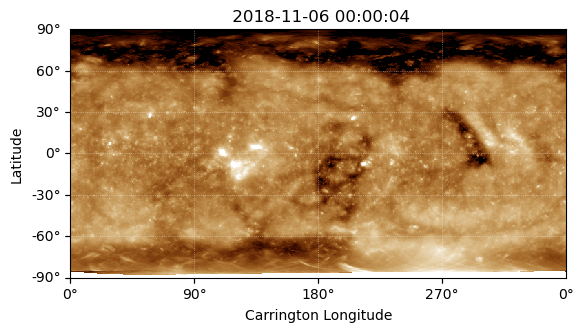

In [4]:
lognorm = mpl.colors.LogNorm(vmin=np.nanpercentile(euvmap.data.flatten(),5), 
                             vmax=np.nanpercentile(euvmap.data.flatten(),99.9))
euvmap.plot(cmap="sdoaia193",norm=lognorm)

### Step 2: Extract CH Contours with CHMAP

In [5]:
ch_for_path = CHmetric.extract_obs_ch(euvmappath,
                                      replace=True,
                                      ezseg_version='fortran',
                                      ezseg_params={
                                          "thresh1":1.5,#np.nanmax(euvmap.data.flatten())*0.07, ## Seed threshold
                                          "thresh2":2,#np.nanmax(euvmap.data.flatten())*0.101, ## Growing Threshhold
                                          "nc":5, ## at least 5 consecutive pixels to declare coronal hole area is connected
                                          "iters":100
                                      }
                                     )
ch_for_map = sunpy.map.Map(ch_for_path)

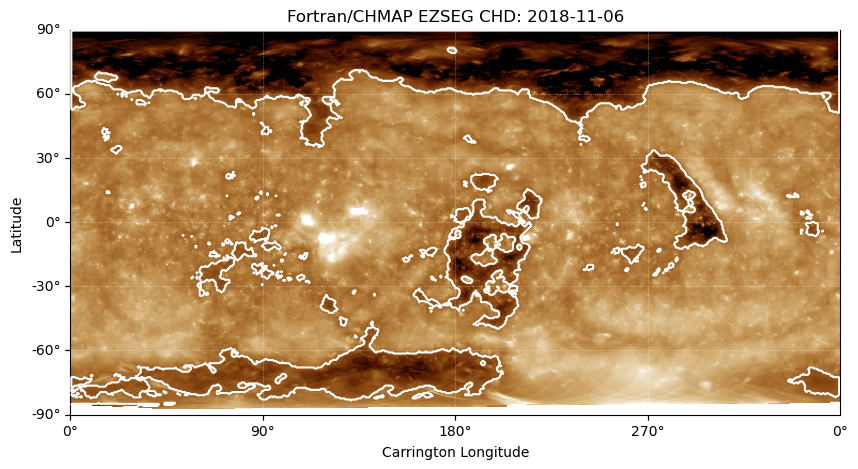

In [6]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection=euvmap.wcs)
euvmap.plot(cmap="sdoaia193",
            norm=lognorm,
            axes=ax
           )
ch_for_map.draw_contours(levels=[0.5,], colors=["white"], axes=ax)

ax.set_title("Fortran/CHMAP EZSEG CHD: " + euvmap.meta['date-obs'][:-13]);

### Step 2 : Extract Coronal Hole Contours with EZSEG

In [7]:
## Takes about a min to run in python
ch_py_path = CHmetric.extract_obs_ch(euvmappath,
                                      replace=False,
                                      ezseg_params={
                                          "thresh1":1.5,#np.nanmax(euvmap.data.flatten())*0.07, ## Seed threshold
                                          "thresh2":2,#np.nanmax(euvmap.data.flatten())*0.101, ## Growing Threshhold
                                          "nc":5, ## at least 7 consecutive pixels to declare coronal hole area is connected
                                          "iters":100
                                      },
                                      ezseg_version="python"
                                     )

ch_py_map = sunpy.map.Map(ch_py_path)

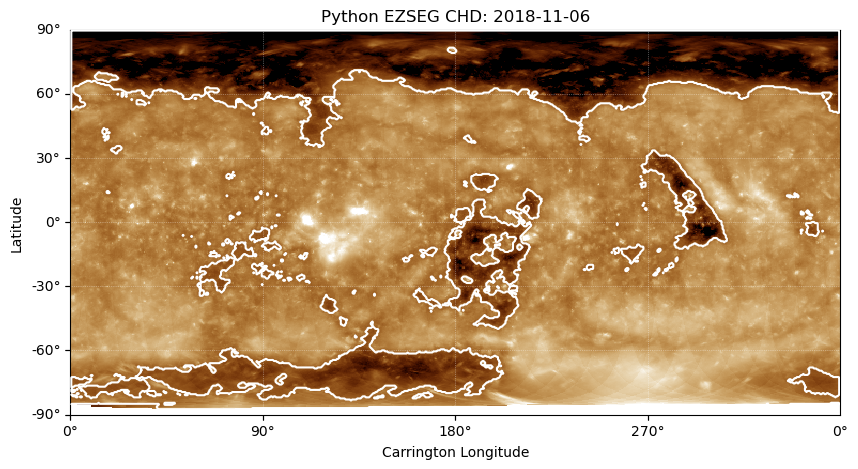

In [8]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection=euvmap.wcs)
euvmap.plot(cmap="sdoaia193",
            norm=lognorm,
            axes=ax
           )
ch_py_map.draw_contours(levels=[0.5,],colors=["white"],axes=ax)
ax.set_title("Python EZSEG CHD: " + euvmap.meta['date-obs'][:-13]);

### Step 3 : Load in Model Coronal Hole Map and Run Binary Classifier to Score

Text(0.5, 1.0, 'Overlap')

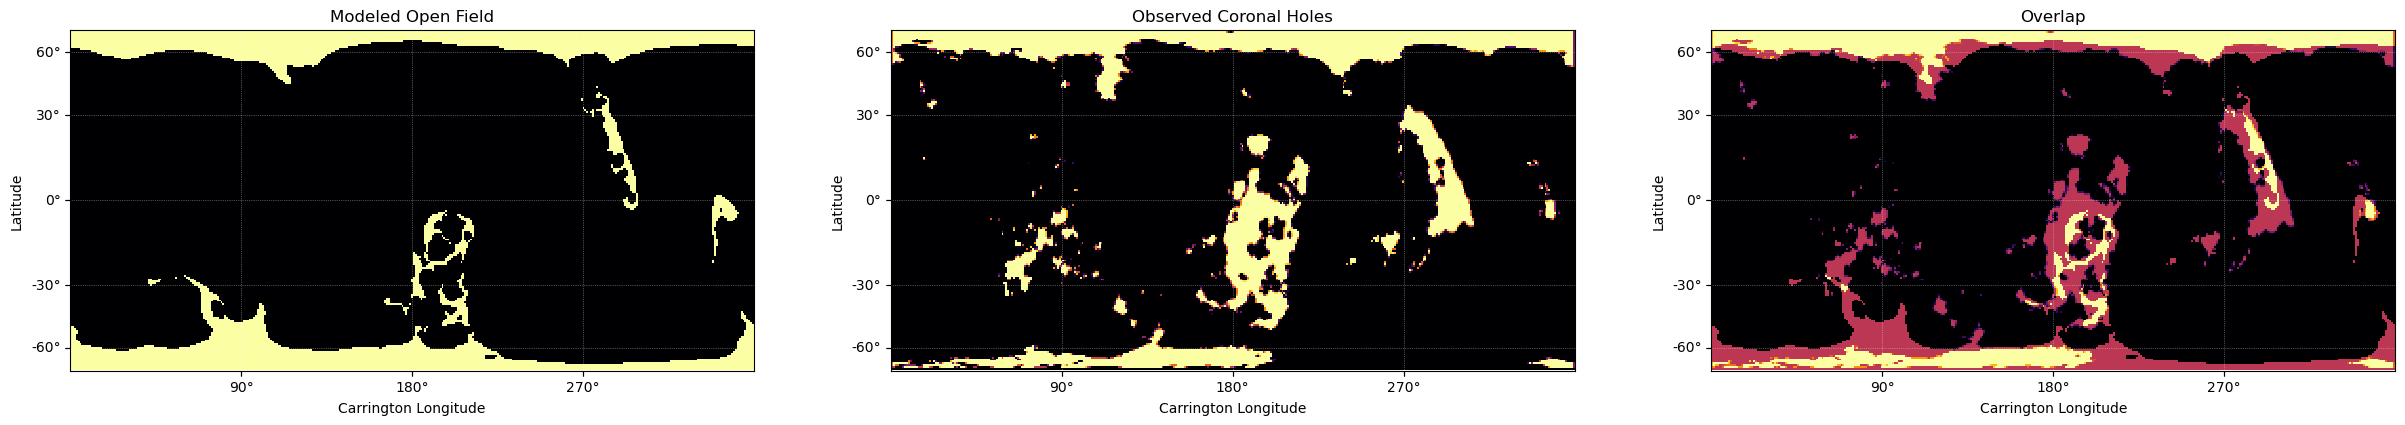

In [9]:
### We have some sample coronal hole and neutral line maps in the folder:
# ./example_model_data/
# Let's choose one
ch_obs_map = ch_for_map # fortran map
ch_obs_path = ch_for_path # fortran map path
chmap_model_example_path = "./example_data/OpenFieldlineMap_Badman_AHMI_2018-11-06_2.5Rs.csv"

# Here's a function that can load these CSV files and port them into a sunpy.map
# as we've been working with above. We need to specify the model time, which we 
# can read from the filename.
datetime_model = datetime.datetime(2018,11,6)
chmap_model_example_map = h.csv2map(chmap_model_example_path,
                                           datetime_model
                                          )

### The model result y-axis is binned in the Cylindrical equal area projection
# while the observation is binned in latitude. We can convert one to the other
# by using the sunpy reprojection api (this also will interpolate the map to 
# the same resolution as the model result, which we also need for doing the
# pixel by pixel classification )
ch_obs_cea = ch_obs_map.reproject_to(chmap_model_example_map.wcs)
ch_combined = sunpy.map.Map(
    ch_obs_cea.data+chmap_model_example_map.data,
    chmap_model_example_map.meta
)
## Now we can plot this side by side with "observed" coronal holes and see
## how they compare
fig = plt.figure(figsize=(30,5))
axmodel = fig.add_subplot(131,projection=chmap_model_example_map.wcs) 
axobs = fig.add_subplot(132,projection=ch_obs_cea.wcs)
axcomb = fig.add_subplot(133,projection=chmap_model_example_map.wcs)
chmap_model_example_map.plot(cmap="inferno",axes=axmodel)
ch_obs_cea.plot(cmap="inferno",axes=axobs)
ch_combined.plot(cmap="inferno",axes=axcomb)
axmodel.set_title("Modeled Open Field")
axobs.set_title("Observed Coronal Holes")
axcomb.set_title("Overlap")

In [10]:
### Lastly, we use the binary classification method defined in Badman+2022 to score the agreement between the models
p,r,f = CHmetric.do_ch_score(datetime_model,
                             chmap_model_example_path,
                             ch_obs_path,
                             auto_interp=True)
print(f"Precision : {100*p:.1f}%, Recall : {100*r:.1f}%, F-Score : {100*f:.1f}%")

Precision : 62.8%, Recall : 55.0%, F-Score : 58.7%


## (B) Streamer Belt Metric (WLmetric)

### Step 1 - Create or Load a White Light Carrington Map

In [11]:
#### Capability to create pending

#### Load Precomputed Ones

### Either download from online source (2020-2023) or download local 

## Load Local File (2018-2020)
WL_date = datetime.datetime(2018,11,6)
WL_path = "./WLmetric/data/"
WL_source = "V1.1"
[WL_fullpath,WL_date] = io_WL.get_WL_map(WL_date,WL_path,WL_source)

## Download from IRAP Connect Tool connect-tool.irap.omp.eu (2020-2023)
# WL_date = datetime.datetime(2021,10,10)
# WL_path = "./WLmetric/data/"
# WL_source = "connect_tool"
# [WL_fullpath,WL_date] = io_WL.get_WL_map(WL_date,WL_path,WL_source)

wlmap = io_WL.WLfile2map(WL_fullpath,WL_date,WL_source)

Local archive: the closest (in time) WL map available from input date: 2018-11-06T00:00:00 is: 2018-11-06 12:00:00


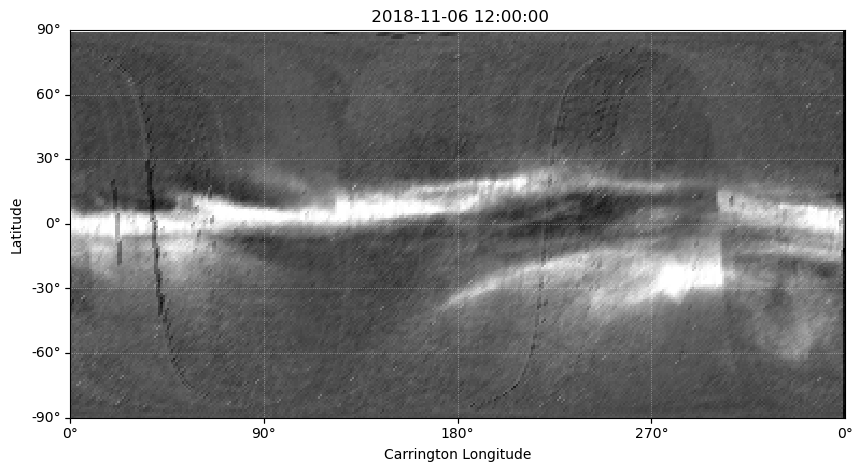

In [12]:
## Let's view what we just loaded in :
fig=plt.figure(figsize=(10,6))
wlmap.plot()

### Step 2 - Extract the Streamer Maximum Brightness Contour

In [13]:
### INPUT : sunpy.map.Map from a White Light Carrington Map
### OUTPUT : astropy.coordinates.SkyCoord describing the 
# location of maximum brightness in the image at each longitude
smb=WLmetric.extract_SMB(wlmap)

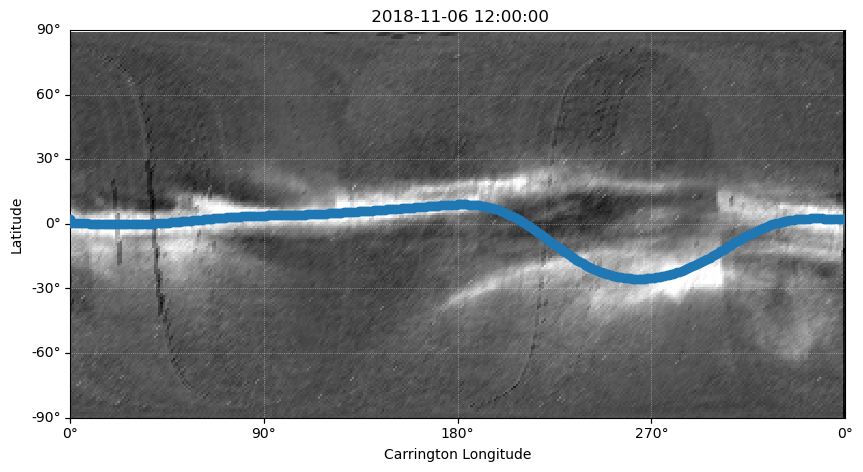

In [14]:
### View the extraction
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(projection=wlmap.wcs)
wlmap.plot(axes=ax)
ax.plot_coord(smb,"o")

### Step 3  - Obtain Equivalent Model Curve and Compute WL Metric Score

In [15]:
### We have some sample coronal hole and neutral line maps in the folder:
# ./example_model_data/
# Let's choose one
nlmap_model_example_path = "./example_data/NeutralLineMap_Badman_AHMI_2018-11-06_2.5Rs.csv"

# Here's a function that can load these CSV files and port them into a sunpy.map
# as we've been working with above. We need to specify the model time, which we 
# can read from the filename.
datetime_model = datetime.datetime(2018,11,6)
nlmap_model_example_map = h.csv2map(nlmap_model_example_path,
                                          datetime_model
                                          )

04-Jun-23 17:43:06: /home/sbadman/anaconda3/envs/coronalmodeleval/lib/python3.11/site-packages/astropy/visualization/wcsaxes/core.py:257: UserWarning: The following kwargs were not used by contour: 'label'
  cset = super().contour(*args, **kwargs)



Text(0.5, 1.0, 'Comparison')

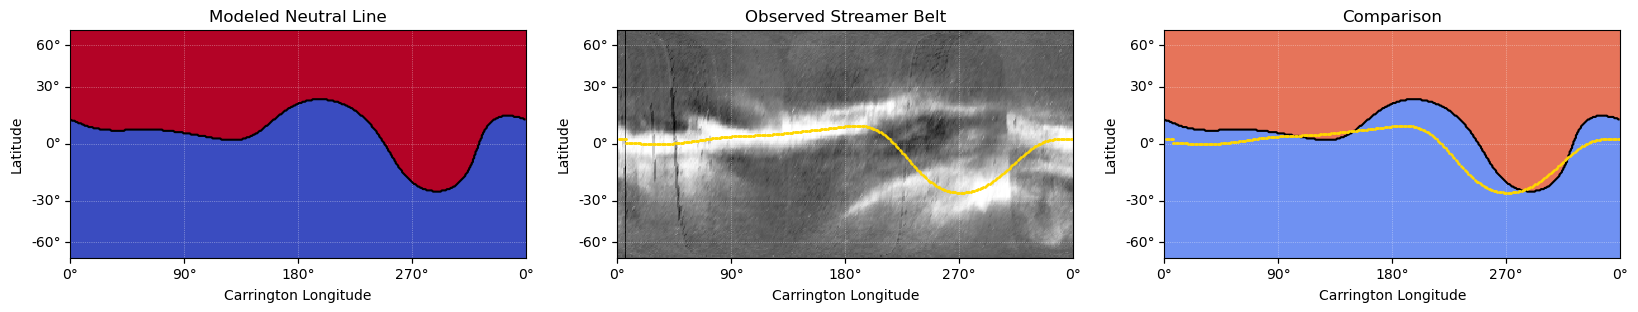

In [16]:
### As with the CHmetric, the observed map is in constant latitude 
# binning. For a fair comparison, we reproject to sine(latitude)
# (CEA) binning.
wl_obs_cea = wlmap.reproject_to(nlmap_model_example_map.wcs)

## Now we can plot the model and observations side by side
fig = plt.figure(figsize=(20,5))
axmodel = fig.add_subplot(131,projection=nlmap_model_example_map.wcs) 
axobs = fig.add_subplot(132,projection=wl_obs_cea.wcs)
axcomp = fig.add_subplot(133,projection=nlmap_model_example_map.wcs)

nlmap_model_example_map.plot(cmap="coolwarm",axes=axmodel)
nlmap_model_example_map.draw_contours(levels=[0],colors=["black"],axes=axmodel)
wl_obs_cea.plot(cmap="Greys_r",axes=axobs)
axobs.plot_coord(smb,"o",color="gold",ms=1)
nlmap_model_example_map.plot(cmap="coolwarm",axes=axcomp,vmin=-1.5,vmax=1.5)
nlmap_model_example_map.draw_contours(levels=[0],colors=["black"],axes=axcomp,label="Model")
axcomp.plot_coord(smb,"o",color="gold",ms=1,label="Observed")

axmodel.set_title("Modeled Neutral Line")
axobs.set_title("Observed Streamer Belt")
axcomp.set_title("Comparison")

In [17]:
### Lastly, we provide these two sets of data to WLmetric to compute the WL Score defined in Poirier+2021, Badman+2022
score = WLmetric.compute_WL_score(nlmap_model_example_map,wlmap)
print(f"WLmetric Score : {score}")

WLmetric Score : 62.10854825947044


## (C) Neutral Line/In Situ Polarity Metric (NLmetric)

### Step 1 : Download and Process Observed Magnetic Polarity timeseries for a few Spacecraft

In [18]:
# todo : save these processed timeseries to files whose names
# reflect the spacecraft, center time and that the times 
# contain a carrington rotation

# todo : figure out how to make the stereo mag data parseable in
# a practical amount of time/computation

dt_center = datetime.datetime(2018,11,6)
observed_field_psp = NLmetric.create_polarity_obs(dt_center,"psp",return_br=True)
observed_field_l1 = NLmetric.create_polarity_obs(dt_center,"L1",return_br=True)
### STEREO data is heavy, takes a few min to run
#observed_field_sta = NLmetric.create_br_obs(dt_center,"stereo-a")

04-Jun-23 17:43:07: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2018/
04-Jun-23 17:43:08: File is current: NLmetric/data/psp/fields/l2/mag_rtn_1min/2018/psp_fld_l2_mag_rtn_1min_20181015_v02.cdf
04-Jun-23 17:43:08: File is current: NLmetric/data/psp/fields/l2/mag_rtn_1min/2018/psp_fld_l2_mag_rtn_1min_20181016_v02.cdf
04-Jun-23 17:43:08: File is current: NLmetric/data/psp/fields/l2/mag_rtn_1min/2018/psp_fld_l2_mag_rtn_1min_20181017_v02.cdf
04-Jun-23 17:43:08: File is current: NLmetric/data/psp/fields/l2/mag_rtn_1min/2018/psp_fld_l2_mag_rtn_1min_20181018_v02.cdf
04-Jun-23 17:43:08: File is current: NLmetric/data/psp/fields/l2/mag_rtn_1min/2018/psp_fld_l2_mag_rtn_1min_20181019_v02.cdf
04-Jun-23 17:43:08: File is current: NLmetric/data/psp/fields/l2/mag_rtn_1min/2018/psp_fld_l2_mag_rtn_1min_20181020_v02.cdf
04-Jun-23 17:43:08: File is current: NLmetric/data/psp/fields/l2/mag_rtn_1min/2018/psp_fld_l2_mag_rtn_1min_20181021_v02.cdf
04-Jun-23 17:43:0

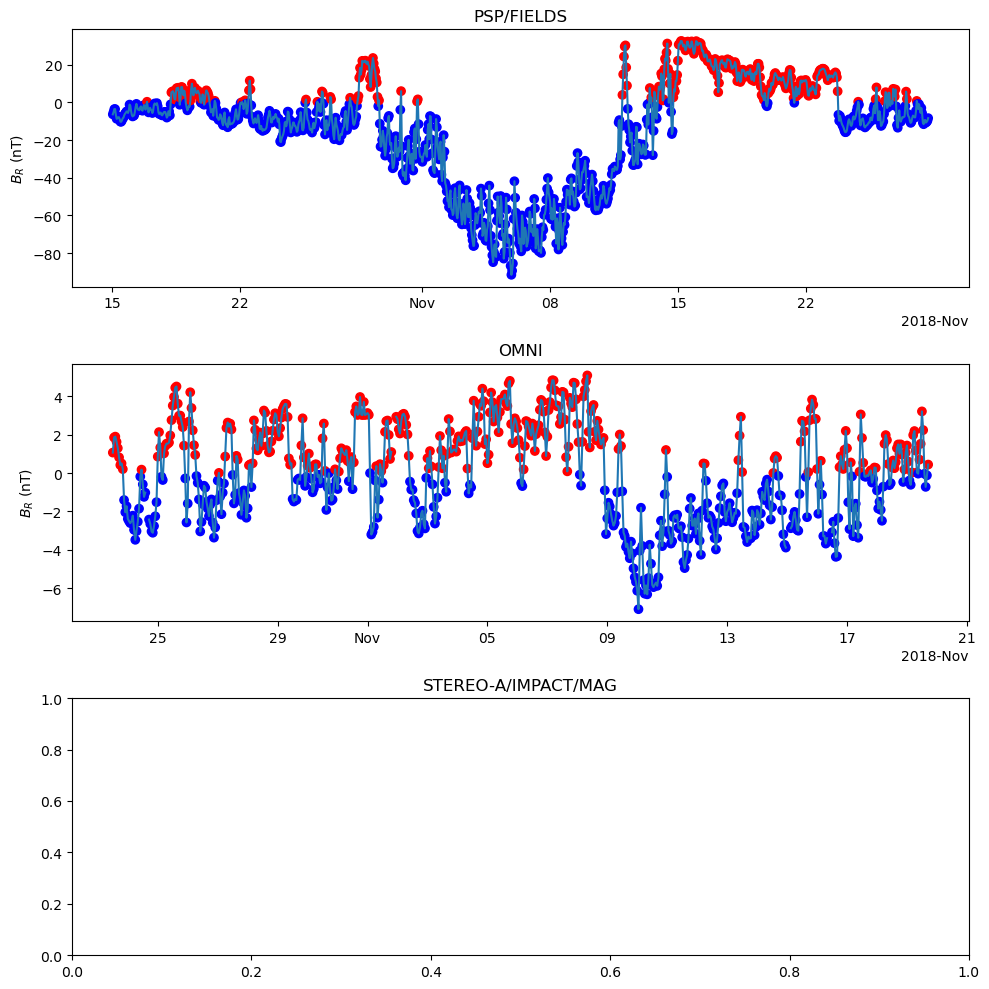

In [19]:
fig,axes=plt.subplots(figsize=(10,10),nrows=3)
for ax,sc in zip(axes,[observed_field_psp,observed_field_l1]):#,observed_field_sta]) :
    ax.plot(*sc)
    ax.scatter(*sc,color=plt.cm.bwr(np.sign(sc[1])))
    ax.set_ylabel("$B_R$ (nT)")
axes[0].set_title("PSP/FIELDS")
axes[1].set_title("OMNI")
axes[2].set_title("STEREO-A/IMPACT/MAG")
plt.tight_layout()

### Step 2 : Make Equivalent Predicted Timeseries according to the model and spacecraft trajectories.

In [20]:
### We have some sample coronal hole and neutral line maps in the folder:
# ./example_model_data/
# Let's choose one
nlmap_model_example_path = "./example_data/NeutralLineMap_Badman_AHMI_2018-11-06_2.5Rs.csv"

# We use the same function as in the WLmetric section to load it in as a sunpy.map.Map
datetime_model = datetime.datetime(2018,11,6)
nlmap_model = h.csv2map(nlmap_model_example_path,
                        datetime_model
                       )

In [21]:
## This function takes the model neutral line map and flies different spacecraft
# over it to produce a predicted timeseries.
polarity_pred_psp=NLmetric.create_polarity_model(nlmap_model,datetime_model,"psp")
polarity_pred_l1=NLmetric.create_polarity_model(nlmap_model,datetime_model,"L1")

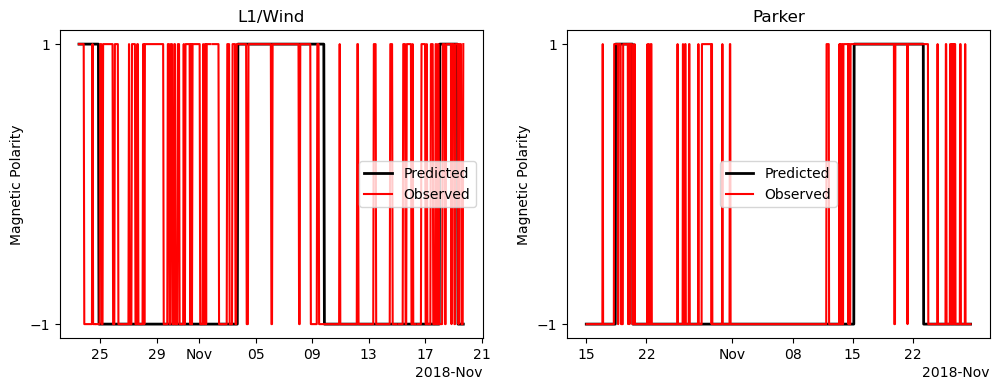

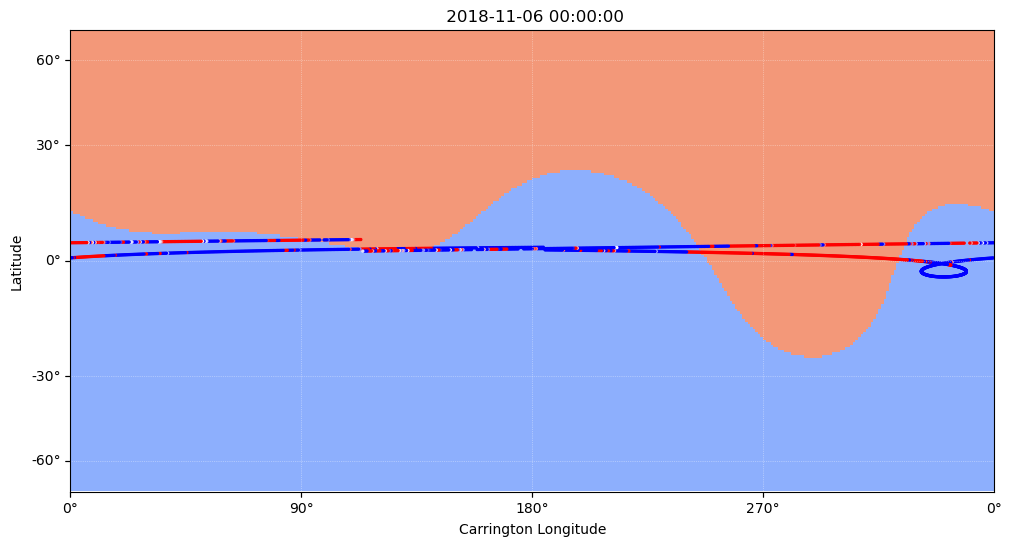

In [22]:
## Now we have produced predicted and measured polarity timeseries, so we can visualize the comparison.

## First, directly by looking at the timeseries
fig,axes = plt.subplots(figsize=(12,4),ncols=2)

axes[0].plot(*polarity_pred_l1,color="black",linewidth=2,label="Predicted")
axes[0].plot(observed_field_l1[0],np.sign(observed_field_l1[1]),color="red",label="Observed")
axes[0].set_title("L1/Wind");axes[1].set_ylabel("Magnetic Polarity")

axes[1].plot(*polarity_pred_psp,color="black",linewidth=2,label="Predicted")
axes[1].plot(observed_field_psp[0],np.sign(observed_field_psp[1]),color="red",label="Observed")
axes[1].set_title("Parker")

for ax in axes: 
    ax.legend()
    ax.set_ylabel("Magnetic Polarity")
    ax.set_yticks([-1,1])

## Second, plot in an easier way to view/understand using the map and the trajectories

# We first need to use some of the helpers to create the trajectories
carrington_trajectory_psp = h.create_carrington_trajectory(
    polarity_pred_psp[0],"psp",obstime_ref=datetime_model
    )
trajectory_psp = h.ballistically_project(carrington_trajectory_psp,
                                               r_inner=2.5*u.R_sun)
carrington_trajectory_l1 = h.create_carrington_trajectory(
    polarity_pred_l1[0],"L1",obstime_ref=datetime_model
    )
trajectory_l1 = h.ballistically_project(carrington_trajectory_l1,
                                               r_inner=2.5*u.R_sun)    

fig=plt.figure(figsize=(12,6))
ax = fig.add_subplot(projection=nlmap_model.wcs)
nlmap_model.plot(cmap="coolwarm",vmin=-2,vmax=2)

ax.scatter(nlmap_model.world_to_pixel(trajectory_psp).x,
           nlmap_model.world_to_pixel(trajectory_psp).y,
           c=plt.cm.bwr(observed_field_psp[1]),s=2
          )
ax.scatter(nlmap_model.world_to_pixel(trajectory_l1).x,
           nlmap_model.world_to_pixel(trajectory_l1).y,
           c=plt.cm.bwr(observed_field_l1[1]),s=2
          )

### Step 3 : Combine Predicted and Observed Timeseries to produce NL metric scores.

In [23]:
### Finally we can go ahead and combine the predicted and measured timeseries
# to produce our NLmetric score for each spacecraft we compare. 

l1_nl_score = NLmetric.compute_NL_metric(polarity_pred_l1,observed_field_l1)
psp_nl_score = NLmetric.compute_NL_metric(polarity_pred_psp,observed_field_psp)

print(f"NLmetric Score : {l1_nl_score}% (L1/Wind), {psp_nl_score}% (Parker)")

NLmetric Score : 0.6146788990825688% (L1/Wind), 0.8789571694599627% (Parker)


### First Tasks :

* Download White Light Carrington map FITS files from  2018-2020 and place in "./WLmetric/data/C2/V1.1/" (available at https://zenodo.org/record/6342187/preview/ConstrainingGlobalCoronalModelsZenodo.zip#tree_item192) and internal Google Drive (ask Sam for link)

* Set up python environment so this notebook works!

* Understand the steps that this notebook goes through, and write out a compact version which repeats everything but just outputs the three sets of scores

* Try varying the input model from ./example_model_data and plot how the scores vary. 
    * Do you notice any trends? 
    * Based on Badman+2022 Fig 4, can you guess what's varying between these example inputs?

### Space for Working